In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
from PIL import Image, ImageOps
import ultralytics
from pathlib import Path

In [1]:
eminst_class_mapping = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B',
               12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M',
               23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X',
               34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q',
               45: 'r', 46: 't'}

In [4]:

def change_to_project_root_dir() -> str:
    current_directory_path: list[str] = os.getcwd().split('\\')
    project_root_dir_as_list: list[str] = current_directory_path[:current_directory_path.index("src")]
    project_root_dir = "\\".join(project_root_dir_as_list)
    os.chdir(project_root_dir)
    return project_root_dir

change_to_project_root_dir()

DIR_NAME = Path("./resources")
DIR_NAME.mkdir(parents=True, exist_ok=True)


In [8]:
current_directory_path: list[str] = os.getcwd().split('\\')
print(current_directory_path)

def extract_zip(zip_path: str, to_path: str):
    # Extract the ZIP file
    print(os.getcwd())
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(to_path)

extract_zip("src/resources/tars/eminst.zip", "resources\\data\\eminst")
        

['C:', 'Users', 'peete', 'Dev', 'ToText']
C:\Users\peete\Dev\ToText


In [9]:
def calculate_row_estimate(csv_path, size_in_mb) -> int:
    sample_size = 1000
    sample_df = pd.read_csv(csv_path, nrows=sample_size)
    avg_row_size = sample_df.memory_usage(deep=True).sum() / sample_size
    target_size_mb = size_in_mb
    target_size_bytes = target_size_mb * 1024 * 1024
    estimated_rows = int(target_size_bytes / avg_row_size)
    print("rows: " + str(estimated_rows))
    return estimated_rows


In [10]:
def load_emnist(folder_path: str, partial: bool = False, size_in_mb: int = 300):
    if partial:
        rows = calculate_row_estimate(folder_path + '/emnist-byclass-train.csv', size_in_mb)
        emnist_train_df: pd.DataFrame = pd.read_csv(folder_path + '/emnist-byclass-train.csv', delimiter=',',
                                                    header=None, nrows=rows)
    else:
        emnist_train_df: pd.DataFrame = pd.read_csv(folder_path + '/emnist-byclass-train.csv', delimiter=',', header=None)
    return emnist_train_df

DIR_NAME = Path("./resources/data/eminst")
DIR_NAME.mkdir(parents=True, exist_ok=True)
df = load_emnist('resources/data/eminst', True, 20)


rows: 3339


In [11]:
from sklearn.model_selection import train_test_split


def filter_by_labels(df: pd.DataFrame, labels: dict) -> pd.DataFrame:
    return df[df[0].isin(labels.keys())].reset_index(drop=True)

def format_to_train_and_test(df: pd.DataFrame, mapping: dict[int: str]):
    X = df.drop(columns=[0], axis=1)
    y = df[0].map(mapping)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    return x_train, x_test, y_train, y_test

df = filter_by_labels(df, eminst_class_mapping)

x_train, x_test, y_train, y_test = format_to_train_and_test(df, eminst_class_mapping)




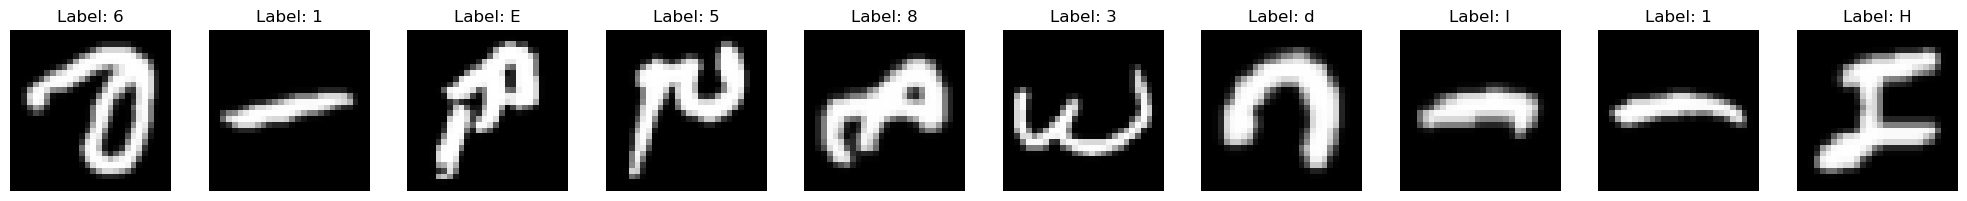

In [12]:
def show_images(x, y, num_images):
    num_cols = num_images
    num_rows = (num_images + num_cols - 1) // num_cols

    plt.figure(figsize=(num_cols * 2, num_rows * 2))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(x.iloc[i].values.reshape(28, 28), cmap='gray')
        plt.title(f"Label: {y.iloc[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
show_images(x_train, y_train, 10)


In [13]:
from PIL import Image, ImageOps
import numpy as np
from pathlib import Path

def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)


def save_image_plotpib(filename, data_array):
    plt.figure(figsize=(1, 1))
    plt.subplot(1, 1, 1)
    # plt.imshow(data_array.values.reshape(28, 28), cmap='gray')
    data_array = np.array(data_array)
    plt.imsave(filename, data_array.reshape(28, 28), cmap='gray')
    plt.tight_layout()
    plt.show()
    return convert((28, 28), (0, 28, 0, 28))


def save_image(filename, data_array):

    #bgcolor = (0xff, 0xff, 0xff)
    bgcolor = (0x00, 0x00, 0xff)
    screen = (640, 640)
    data_array = np.array(data_array)
    data_array = np.resize(data_array, (28, 28)).astype(np.uint8)
    img = Image.new('RGB', screen, bgcolor)

    mnist_img = Image.fromarray(data_array.astype('uint8'))
    mnist_img_invert = ImageOps.invert(mnist_img)

    #w = int(round(mnist_img.width * random.uniform(8.0, 10.0)))
    w = int(mnist_img.width*10)
    mnist_img_invert = mnist_img_invert.resize((w,w))

    #x = random.randint(0, img.width-w)
    #y = random.randint(0, img.height-w)
    x = int((img.width-w)/2)
    y = int((img.height-w)/2)
    img.paste(mnist_img_invert, (x, y))
    img.save(filename)

    return convert((img.width,img.height), (float(x), float(x+w), float(y), float(y+w)))



def format_to_yolo(filepath: str, x: pd.DataFrame, labels: pd.DataFrame):
# the data, shuffled and split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
    DIR_NAME = Path(filepath + "images")
    DIR_NAME.mkdir(parents=True, exist_ok=True)
    
    LABEL_DIR_NAME = Path(filepath + "labels")
    LABEL_DIR_NAME.mkdir(parents=True, exist_ok=True)
    
    x = x.to_numpy()
    labels = labels.to_numpy()
    for enum, row in enumerate(x):
        # Write Image file
        filename = "{0}/{1:05d}.jpg".format(DIR_NAME,enum)
        ret = save_image(filename, row)
        print(filename)
        print(ret)
        # Write label file
        label_filename = "{0}/{1:05d}.txt".format(LABEL_DIR_NAME,enum)
        f = open(label_filename, 'w')
        y = labels[enum]
        _str = f"{y} {ret[0]} {ret[1]} {ret[2]} {ret[3]}"
        f.write(_str)
        f.close()
        
format_to_yolo("resources/data/yolo/train/", x_train, y_train)
format_to_yolo("resources/data/yolo/test/", x_test, y_test)


resources\data\yolo\train\images/00000.jpg
(0.5, 0.5, 0.4375, 0.4375)
resources\data\yolo\train\images/00001.jpg
(0.5, 0.5, 0.4375, 0.4375)
resources\data\yolo\train\images/00002.jpg
(0.5, 0.5, 0.4375, 0.4375)
resources\data\yolo\train\images/00003.jpg
(0.5, 0.5, 0.4375, 0.4375)
resources\data\yolo\train\images/00004.jpg
(0.5, 0.5, 0.4375, 0.4375)
resources\data\yolo\train\images/00005.jpg
(0.5, 0.5, 0.4375, 0.4375)
resources\data\yolo\train\images/00006.jpg
(0.5, 0.5, 0.4375, 0.4375)
resources\data\yolo\train\images/00007.jpg
(0.5, 0.5, 0.4375, 0.4375)
resources\data\yolo\train\images/00008.jpg
(0.5, 0.5, 0.4375, 0.4375)
resources\data\yolo\train\images/00009.jpg
(0.5, 0.5, 0.4375, 0.4375)
resources\data\yolo\train\images/00010.jpg
(0.5, 0.5, 0.4375, 0.4375)
resources\data\yolo\train\images/00011.jpg
(0.5, 0.5, 0.4375, 0.4375)
resources\data\yolo\train\images/00012.jpg
(0.5, 0.5, 0.4375, 0.4375)
resources\data\yolo\train\images/00013.jpg
(0.5, 0.5, 0.4375, 0.4375)
resources\data\yolo\

In [ ]:
from ultralytics import YOLO
import torch
torch.cuda.empty_cache()

model = YOLO("YOLOv8n.yaml")

res = model.train(data="src/training/train.yaml", epochs=10, imgsz=640, batch=5, degrees=5.0, translate=0.2, perspective=0.00001, scale=0.5, shear=0.1, mosaic=0.2, mixup=0.2, patience=0)

In [15]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Device count: {torch.cuda.device_count()}")
print(f"Device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'}")

CUDA available: False
CUDA version: None
Device count: 0
Device name: N/A
